In [1]:
import warnings
warnings.filterwarnings('ignore')

### Data preparation

In [2]:
%%time
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import cv2
from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt

from glob import glob
import os

imPath = "Database/All_pictures/"
ls_path = glob(os.path.join(imPath, '*' ))


images_base_vide=[]
label_nom_vide=[]

for file in ls_path: 
    im = np.array(Image.open(file))[:,:,3]   #On charge l'image
    images_base_vide+=[im]
    label_nom_vide+=[file.split('/')[2].split('_')[0]]   ## Attention ici Solène si ça marche pas . Pas meme code pour chemin ...

images_base_raw=np.array(images_base_vide)
label_nom_raw=np.array(label_nom_vide)

def print_exemple_image(num_image,X=images_base_raw,y=label_nom_vide) :
    plt.imshow(X[num_image],cmap='Greys')
    plt.suptitle("Image n°"+str(num_image)+" : "+str(y[num_image]), fontsize=20)
    
from sklearn.model_selection import train_test_split

ramdom_seed_fixée=5

def get_split_classique() :
    return train_test_split(images_base_raw, label_nom_raw, test_size=0.20, random_state=ramdom_seed_fixée)

X_train_classique , X_test_classique , Y_train_classique , Y_test_classique = get_split_classique()

label_to_OneHot = {'Deezer':[1,0,0,0],'Messenger':[0,1,0,0],'Facebook':[0,0,1,0],'Tinder':[0,0,0,1]}
label_to_num = {'Deezer':0 ,'Messenger':1 ,'Facebook':2,'Tinder':3} 
num_to_label={0:'Deezer',1:'Messenger' ,2:'Facebook',3:'Tinder'}

def transformation_dictionnaire_image(X,Y,data_aug=1,num_pixel_cote=64) : 
    taille = X.shape[0]
    data_base={'image':[], 'data': [], 'label_num' : [],'label_OneHot' : [],'nom_label' :[]}
    for i in range(taille) : 
        im = cv2.resize(X[i], (num_pixel_cote,num_pixel_cote))
        name=Y[i]
        
        for k in range(data_aug):
            num_rows, num_cols = im.shape[:2]
            rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), k*90, 1)
            im_rotation = cv2.warpAffine(im, rotation_matrix, (num_cols, num_rows))
        
            
            data_base['image']+=[im_rotation]
            data_base['data']+=[np.ndarray.flatten(im_rotation)]
            data_base['label_num']+=[label_to_num[name]]
            data_base['label_OneHot']+=[label_to_OneHot[name]]
            data_base['nom_label']+=[name]
            
            
    data_base['image']=np.array( data_base['image'])
    data_base['data']=np.array(data_base['data'])
    data_base['label_num']=np.array(data_base['label_num'])
    data_base['label_OneHot']=np.array(data_base['label_OneHot'])
    data_base['nom_label']=np.array(data_base['nom_label'])
    
    return data_base
        
Train_Classique = transformation_dictionnaire_image(X_train_classique,Y_train_classique)
Test_Classique = transformation_dictionnaire_image(X_test_classique,Y_test_classique)

catégories= ['Deezer','Facebook','Messenger','Tinder']

X_train_progressif , X_test_progressif , Y_train_progressif , Y_test_progressif = [],[],[],[]

for cat in catégories : 
    imPath = "Database/"+cat+"/"
    ls_path = glob(os.path.join(imPath, '*' ))

    taille_train=len(ls_path)-len(ls_path)//5
    #Train
    for file in ls_path[:taille_train]: 
        im = np.array(Image.open(file))[:,:,3]   #On charge l'image
        X_train_progressif+=[im]
        Y_train_progressif+=[file.split('/')[2].split('_')[0]]

    #Test
    for file in ls_path[taille_train:]: 
        im = np.array(Image.open(file))[:,:,3]   #On charge l'image
        X_test_progressif+=[im]
        Y_test_progressif+=[file.split('/')[2].split('_')[0]]
    

X_train_progressif=np.array(X_train_progressif)
Y_train_progressif=np.array(Y_train_progressif)
X_test_progressif=np.array(X_test_progressif)
Y_test_progressif=np.array(Y_test_progressif)


Train_Progressif = transformation_dictionnaire_image(X_train_progressif,Y_train_progressif)
Test_Progressif = transformation_dictionnaire_image(X_test_progressif,Y_test_progressif)

CPU times: user 13.9 s, sys: 3.23 s, total: 17.1 s
Wall time: 17.2 s


In [3]:
Train_dic=Train_Classique
Test_dic=Test_Classique

In [4]:
# Nombre pixel coté
img_size = Train_dic['image'].shape[1]

# Nombre de pixel au total
img_size_flat = Train_dic['data'].shape[1]

# Nombre de pixel longeur et largeur 
img_shape = Train_dic['image'].shape[1:]

# Nombre de classes (si on ajoute de nouveaux logos)
num_classes = 4 

=> Multiclass classification algorithms. Let's try some and compair them

https://scikit-learn.org/stable/modules/multiclass.html

In [5]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns; sns.set()

### 1) Logistic Regression

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score

In [7]:
regr = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') 
regr.fit(Train_dic['data'], Train_dic['label_num']) 
ypred_ML1 = regr.predict(Test_dic['data'])

In [8]:
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(Test_dic['label_num'], ypred_ML1))
# Explained variance score: 
print('Variance score: %.2f' % r2_score(Test_dic['label_num'], ypred_ML1))



Coefficients: 
 [[ 0.00000000e+00 -8.50044761e-06  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.20998797e-05  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.18255019e-05  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.22517462e-06  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
Mean squared error: 1.15
Variance score: 0.05


In [9]:
print(metrics.classification_report(ypred_ML1, Test_dic['label_num']))

             precision    recall  f1-score   support

          0       0.57      0.54      0.55        70
          1       0.38      0.41      0.39        71
          2       0.59      0.48      0.53        98
          3       0.48      0.59      0.53        64

avg / total       0.51      0.50      0.50       303



In [10]:
# Accuracy Score
print(metrics.accuracy_score(ypred_ML1, Test_dic['label_num']))

0.5016501650165016


Text(84.4,0.5,'Prédite')

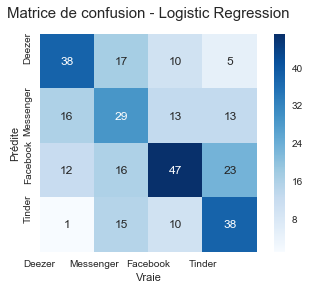

In [11]:
# Matrice de confusion 

mat = confusion_matrix(Test_dic['label_num'], ypred_ML1)
sns.heatmap(mat.T, cmap="Blues", square=True, annot=True)

plt.title('Matrice de confusion - Logistic Regression', y=1.05, size=15)

tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, [num_to_label[i] for i in range(num_classes)])
plt.yticks(tick_marks, [num_to_label[i] for i in range(num_classes)])
plt.xlabel('Vraie')
plt.ylabel('Prédite')

### 2) Arbre de Décision

In [12]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [13]:
Decision = DecisionTreeClassifier()
Decision.fit(Train_dic['data'], Train_dic['label_num'])
ypred_ML2 = Decision.predict(Test_dic['data'])

In [14]:
print(metrics.classification_report(ypred_ML2, Test_dic['label_num']))

             precision    recall  f1-score   support

          0       0.46      0.34      0.39        92
          1       0.34      0.42      0.37        62
          2       0.46      0.46      0.46        81
          3       0.39      0.46      0.42        68

avg / total       0.42      0.41      0.41       303



In [15]:
# Accuracy Score
print(metrics.accuracy_score(ypred_ML2, Test_dic['label_num']))

0.41254125412541254


Text(84.4,0.5,'Prédite')

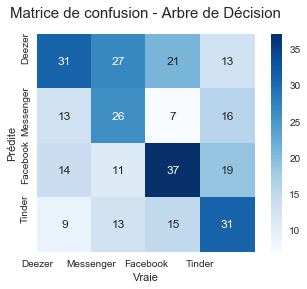

In [16]:
# Matrice de confusion 

mat = confusion_matrix(Test_dic['label_num'], ypred_ML2)
sns.heatmap(mat.T, cmap="Blues", square=True, annot=True)

plt.title('Matrice de confusion - Arbre de Décision', y=1.05, size=15)

tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, [num_to_label[i] for i in range(num_classes)])
plt.yticks(tick_marks, [num_to_label[i] for i in range(num_classes)])
plt.xlabel('Vraie')
plt.ylabel('Prédite')


### 3) Random Forest 

In [17]:
from sklearn.ensemble import RandomForestClassifier

In [18]:
model = RandomForestClassifier()
model.fit(Train_dic['data'],Train_dic['label_num'])
ypred_ML3 = model.predict(Test_dic['data'])

In [19]:
print(metrics.classification_report(ypred_ML3, Test_dic['label_num']))

             precision    recall  f1-score   support

          0       0.64      0.44      0.52        97
          1       0.36      0.41      0.39        68
          2       0.53      0.51      0.52        82
          3       0.34      0.48      0.40        56

avg / total       0.49      0.46      0.47       303



In [20]:
# Accuracy Score
print(metrics.accuracy_score(ypred_ML3, Test_dic['label_num']))

0.46204620462046203


Text(84.4,0.5,'Prédite')

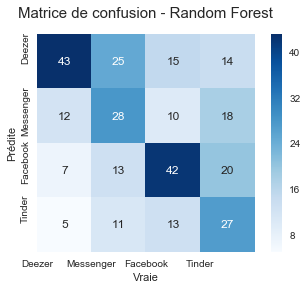

In [21]:
# Matrice de confusion 

mat = confusion_matrix(Test_dic['label_num'], ypred_ML3)
sns.heatmap(mat.T, cmap="Blues", square=True, annot=True)

plt.title('Matrice de confusion - Random Forest', y=1.05, size=15)

tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, [num_to_label[i] for i in range(num_classes)])
plt.yticks(tick_marks, [num_to_label[i] for i in range(num_classes)])
plt.xlabel('Vraie')
plt.ylabel('Prédite')

### 4) AdaBoostClassifier

In [22]:
from sklearn.ensemble import AdaBoostClassifier

In [23]:
AdaBoost = AdaBoostClassifier()
AdaBoost.fit(Train_dic['data'], Train_dic['label_num']) 
ypred_ML4 = AdaBoost.predict(Test_dic['data'])


In [24]:
print(metrics.classification_report(ypred_ML4, Test_dic['label_num']))

             precision    recall  f1-score   support

          0       0.49      0.52      0.50        64
          1       0.38      0.44      0.41        66
          2       0.50      0.39      0.44       103
          3       0.49      0.56      0.52        70

avg / total       0.47      0.47      0.46       303



In [25]:
# Accuracy Score
print(metrics.accuracy_score(ypred_ML4, Test_dic['label_num']))

0.46534653465346537


Text(84.4,0.5,'Prédite')

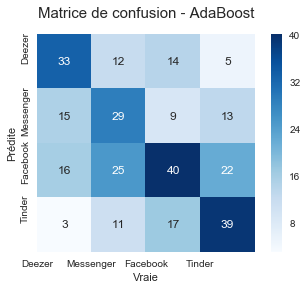

In [26]:
# Matrice de confusion 

mat = confusion_matrix(Test_dic['label_num'], ypred_ML4)
sns.heatmap(mat.T, cmap="Blues", square=True, annot=True)

plt.title('Matrice de confusion - AdaBoost', y=1.05, size=15)

tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, [num_to_label[i] for i in range(num_classes)])
plt.yticks(tick_marks, [num_to_label[i] for i in range(num_classes)])
plt.xlabel('Vraie')
plt.ylabel('Prédite')

### 5) One vs. all 

In [27]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

In [28]:
OVR= OneVsRestClassifier(LinearSVC(random_state=0))
OVR.fit(Train_dic['data'], Train_dic['label_num']) 
ypred_ML5 = OVR.predict(Test_dic['data'])

In [29]:
print(metrics.classification_report(ypred_ML5, Test_dic['label_num']))

             precision    recall  f1-score   support

          0       0.61      0.48      0.54        85
          1       0.29      0.40      0.33        55
          2       0.59      0.47      0.52       100
          3       0.44      0.56      0.49        63

avg / total       0.51      0.48      0.49       303



In [30]:
# Accuracy Score
print(metrics.accuracy_score(ypred_ML5, Test_dic['label_num']))

0.47854785478547857


Text(84.4,0.5,'Prédite')

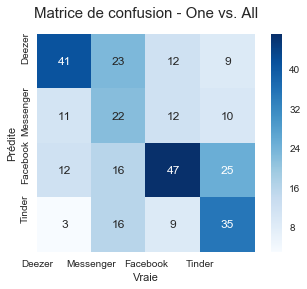

In [31]:
# Matrice de confusion 

mat = confusion_matrix(Test_dic['label_num'], ypred_ML5)
sns.heatmap(mat.T, cmap="Blues", square=True, annot=True)

plt.title('Matrice de confusion - One vs. All', y=1.05, size=15)

tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, [num_to_label[i] for i in range(num_classes)])
plt.yticks(tick_marks, [num_to_label[i] for i in range(num_classes)])
plt.xlabel('Vraie')
plt.ylabel('Prédite')